In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import skfda
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import skfda
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)
import scipy

from sklearn.decomposition import PCA


In [2]:
gait_df = pd.read_csv("gait.csv")
gait_df.head()

,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127
2,1,1,1,1,1,2,5.229774
3,1,1,1,1,1,3,5.083273
4,1,1,1,1,1,4,4.652399


In [10]:
def extract_corrected_angle_series(df, condition, joint=1):
    # Filter the DataFrame for the specified condition and joint
    filtered_df = df[(df['condition'] == condition) & (df['joint'] == joint)]
    # Extract angle time series grouped by subject, replication, and leg
    series_list = filtered_df.groupby(['subject', 'replication', 'leg'])['angle'].apply(list).tolist()
    return series_list

# Apply the function for condition 1 and 2 with joint=1
angle_series_condition_1 = extract_corrected_angle_series(gait_df, 1,1)
angle_series_condition_2 = extract_corrected_angle_series(gait_df, 2,1)


def extract_legs_by_condition(df, condition, joint=1):
    filtered_df = df[(df['condition'] == condition) & (df['joint'] == joint)]
    legs = filtered_df.groupby(['subject', 'replication', 'leg'])['leg'].first().tolist()
    return legs

legs_condition_1 = extract_legs_by_condition(gait_df, 1, 1)
legs_condition_2 = extract_legs_by_condition(gait_df, 2, 1)
# Assuming you want to combine these for a unified plot
combined_legs = legs_condition_1 + legs_condition_2




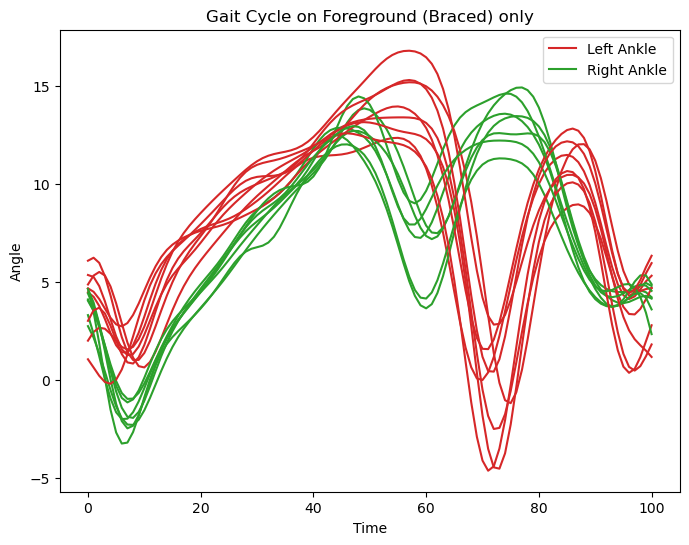

In [11]:
import matplotlib.pyplot as plt

def plot_angle_series_by_leg(angle_series_list, legs, title="Angle Series by Leg"):
    # Colors for different legs
    leg_colors = {1: 'tab:red', 2: 'tab:green'}
    # Mapping for leg numbers to descriptions
    leg_descriptions = {1: 'Left Ankle', 2: 'Right Ankle'}
    
    plt.figure(figsize=(8, 6))
    
    # Ensure legend entries are unique
    added_legends = set()

    # Plot only the first 15 angle series
    for series, leg in zip(angle_series_list[:15], legs[:15]):
        label = leg_descriptions[leg]
        if label not in added_legends:
            plt.plot(series, color=leg_colors[leg], label=label)
            added_legends.add(label)
        else:
            plt.plot(series, color=leg_colors[leg])
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Angle")
    plt.legend()
    plt.show()

# Example usage
# This assumes angle_series_condition_2 is already defined and matches the extracted series data
# And that legs_condition_2 is a list indicating whether each series corresponds to the left or right leg
plot_angle_series_by_leg(angle_series_condition_2, legs_condition_2, "Gait Cycle on Foreground (Braced) only")


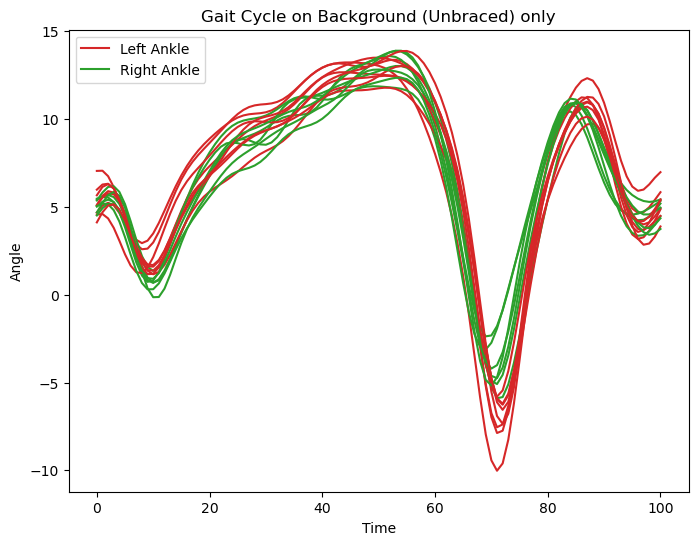

In [12]:
plot_angle_series_by_leg(angle_series_condition_1, legs_condition_2, "Gait Cycle on Background (Unbraced) only")


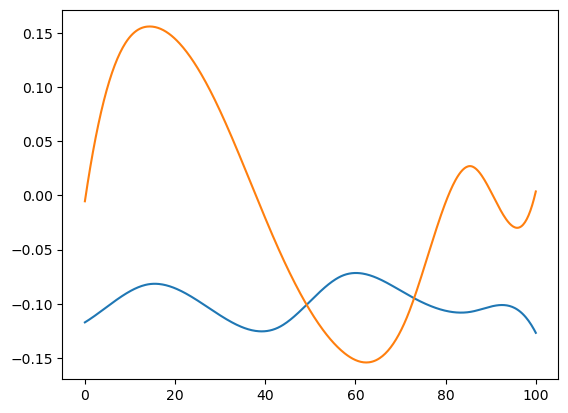

In [13]:
t = np.linspace(0, 100, 101)

# Convert residuals to FDataGrid format
fd = skfda.FDataGrid(standardized_normal_list, t)

# Convert to Fourier basis representation
basis = BSplineBasis(n_basis=10)
basis_fd = fd.to_basis(basis)

# Perform FPCA on the residuals in basis representation
fpca = FPCA(n_components=2, components_basis=basis)
fpca.fit(basis_fd)

# Plot FPCA components
fpca.components_.plot();

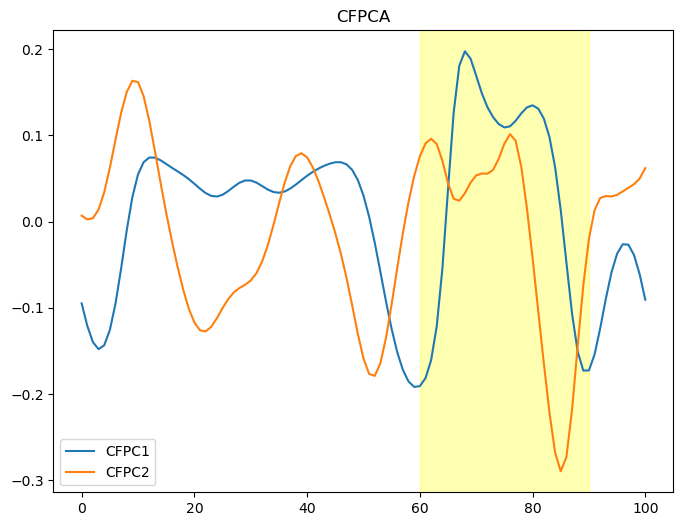

In [15]:
import numpy as np

def standardize_time_series(data_list, log_transform=False, individual=False, across_time_points=False):
    """
    Standardize time series data based on selected options.

    Parameters:
    - data_list: List of lists, where each inner list represents a time series.
    - log_transform: Boolean, if True, apply log transformation to the data before standardizing.
    - individual: Boolean, if True, standardize each time series individually.
    - across_time_points: Boolean, if True, standardize across all time points.

    Returns:
    - List of standardized time series data.
    """

    # Apply log transformation if requested
    if log_transform:
        data_list = np.log1p(data_list)

    if individual:
        # Standardize each series individually
        standardized_data = [(series - np.mean(series)) / np.std(series) for series in data_list]
    
    elif across_time_points:
        # Convert to NumPy array for easier manipulation
        data_array = np.array(data_list)
        # Standardize across all time points
        means = np.mean(data_array, axis=0)
        stds = np.std(data_array, axis=0)
        standardized_data = (data_array - means) / stds
        standardized_data = standardized_data.tolist()
    
    else:
        # Default behavior if neither individual nor across_time_points is specified
        raise ValueError("Either 'individual' or 'across_time_points' must be True.")

    return standardized_data



def compute_and_plot_components(foreground, background, alpha):
    # Define time points
    t = np.linspace(0, 100, 101)
    fd_X = skfda.FDataGrid(foreground, t)
    fd_Y = skfda.FDataGrid(background, t)
    basis = skfda.representation.basis.BSplineBasis(n_basis=7)
    X_basis = fd_X.to_basis(basis)
    Y_basis = fd_Y.to_basis(basis)

    X_fd_data = fd_X.data_matrix.reshape(fd_X.data_matrix.shape[:-1])
    Y_fd_data = fd_Y.data_matrix.reshape(fd_Y.data_matrix.shape[:-1])

    X_identity = np.eye(len(fd_X.grid_points[0]))
    Y_identity = np.eye(len(fd_Y.grid_points[0]))

    X_weights = scipy.integrate.simpson(X_identity, fd_X.grid_points[0])
    Y_weights = scipy.integrate.simpson(Y_identity, fd_Y.grid_points[0])

    X_weights_matrix = np.diag(X_weights)
    Y_weights_matrix = np.diag(Y_weights)

    X_factorization_matrix = X_weights_matrix.astype(float)
    Y_factorization_matrix = Y_weights_matrix.astype(float)

    X_Lt = np.linalg.cholesky(X_factorization_matrix).T
    Y_Lt = np.linalg.cholesky(Y_factorization_matrix).T

    new_data_matrix_X = X_fd_data @ X_weights_matrix
    new_data_matrix_X = np.linalg.solve(X_Lt.T, new_data_matrix_X.T).T

    new_data_matrix_Y = Y_fd_data @ Y_weights_matrix
    new_data_matrix_Y = np.linalg.solve(Y_Lt.T, new_data_matrix_Y.T).T
    
    X_centered = new_data_matrix_X
    Y_centered = new_data_matrix_Y

    # Center the matrix X by subtracting the mean of each column
   # X_centered = new_data_matrix_X - np.mean(new_data_matrix_X, axis=0)
   # Y_centered = new_data_matrix_Y - np.mean(new_data_matrix_Y, axis=0)

    Vx = (1 / (len(foreground) - 1)) * np.dot(X_centered.T, X_centered)
    Vy = (1 / (len(background) - 1)) * np.dot(Y_centered.T, Y_centered)

    # Perform the eigen decomposition on the covariance matrix V
    eigenvalues, eigenvectors = np.linalg.eig(Vx - alpha * Vy)

    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    components = np.linalg.solve(X_Lt, sorted_eigenvectors[:, :5]).T

    # Plot the first three components
    plt.figure(figsize=(8, 6))
    for i in range(2):
        plt.plot(components[i], label=f'Component {i+1}')
    #plt.legend()
    plt.title('CFPCA')
    plt.axvspan(60, 90, color='yellow', alpha=0.3)

    plt.legend(['CFPC1', 'CFPC2'])
    plt.show()

    return components

standardized_brace_list = standardize_time_series(angle_series_condition_2, log_transform=False, individual=False, across_time_points = True)
standardized_normal_list = standardize_time_series(angle_series_condition_1, log_transform=False, individual=False, across_time_points=True)


# Example usage:
#shared_components = compute_and_plot_components(standardized_normal_list,standardized_brace_list , 0)
unique_components = compute_and_plot_components(standardized_brace_list,standardized_normal_list, 2)

#NON PERIODIC CASE

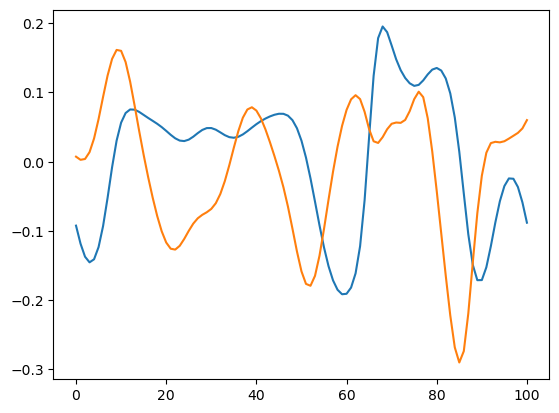

In [18]:
X = np.array(standardized_brace_list)
Y = np.array(standardized_normal_list)
w = 1
X = X - np.mean(X, axis = 0)
Y = Y - np.mean(Y, axis = 0)
#X = StandardScaler().fit_transform(X)
#Y = StandardScaler().fit_transform(Y)
N = len(X)
M = len(Y)
Vx = (1/(N-1)) * np.dot(X.T, X)
Vy = (1/(M-1)) * np.dot(Y.T, Y)


# Perform the eigen decomposition on the covariance matrix V
eigenvalues, eigenvectors = np.linalg.eig(Vx-2*Vy)

# Sort the eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]


plt.plot(t, (w**(-0.5))*sorted_eigenvectors[:,0])
plt.plot(t, (w**(-0.5))*sorted_eigenvectors[:,1])

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps


def calculate_pc_scores_from_lists(data_lists, eigenvector):
    """
    Calculate the PC scores for each time series represented by a list in data_lists.
    
    Parameters:
    - data_lists: List of lists, each inner list is a time series for a company.
    - eigenvector: The eigenvector to use for calculating PC scores.
    - t: The time array over which to integrate.
    
    Returns:
    - A numpy array with PC scores for each time series.
    """
    # Convert data lists to a numpy array for efficient computation
    data_array = np.array(data_lists)
    
    # Calculate the integral using the trapezoidal rule for each time series
    pc_scores = np.array([simps(data_array[i] * np.real(eigenvector), dx = 1) for i in range(data_array.shape[0])])
    return pc_scores


unique_pc_score1 = calculate_pc_scores_from_lists(standardized_brace_list, (w**(-0.5))*sorted_eigenvectors[:,0])
unique_pc_score2 = calculate_pc_scores_from_lists(standardized_brace_list, (w**(-0.5))*sorted_eigenvectors[:,1])



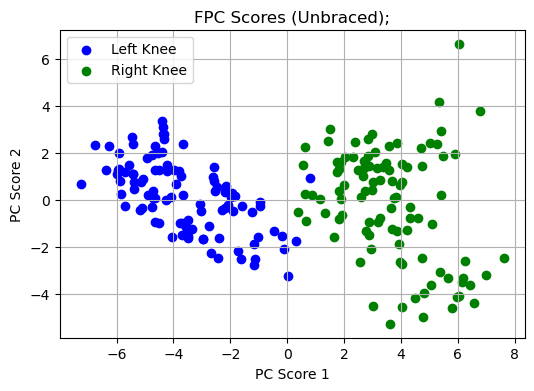

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

def plot_pc_scores_with_labels(pc_scores1, pc_scores2, legs, title="CFPC Scores"):
    plt.figure(figsize=(6, 4))  # Adjusted for better visibility of labels and colors
    texts = []  # List to store all the text objects for adjust_text
    colors = ['blue' if leg == 1 else 'green' for leg in legs]  # Assuming 1 for left and 2 for right, adjust as necessary
    
    # Plot each point, now colored by leg
    for i in range(len(pc_scores1)):
        plt.scatter(pc_scores1[i], pc_scores2[i], color=colors[i])  # Color by leg
    
    plt.xlabel('PC Score 1')
    plt.ylabel('PC Score 2')
    plt.title(title)
    plt.grid(True)  # Optional: Adds a grid for better readability
    
    # Legend
    plt.scatter([], [], color='blue', label='Left Knee')
    plt.scatter([], [], color='green', label='Right Knee')
    plt.legend()
    
    # Use adjust_text to minimize text overlaps

    plt.show()
#\u03b3 = 0
# Example usage
# Assuming you have pc_scores1, pc_scores2, and legs ready
plot_pc_scores_with_labels(unique_pc_score1, unique_pc_score2, legs_condition_1, "FPC Scores (Unbraced);")


In [21]:
X = np.column_stack((unique_pc_score1, unique_pc_score2))

# Calculate Silhouette Score
sil_score = silhouette_score(X, legs_condition_2)
print("Silhouette Score:", sil_score)

# Calculate Davies-Bouldin Score
db_score = davies_bouldin_score(X, legs_condition_2)
print("Davies-Bouldin Score:", db_score)

Silhouette Score: 0.5659615748120693
Davies-Bouldin Score: 0.6402237770121352


In [129]:
def extract_corrected_angle_series_by_leg(df, condition, leg):
    """
    Extracts angle time series from the specified leg and condition,
    grouping the data by subject, replication, and joint.
    """
    # Filter the DataFrame for the specified condition and leg
    filtered_df = df[(df['condition'] == condition) & (df['leg'] == leg)]
    # Extract angle time series grouped by subject, replication, and joint
    series_list = filtered_df.groupby(['subject', 'replication', 'joint'])['angle'].apply(list).tolist()
    return series_list

# For example, to extract angle series for the right leg (leg=2) under conditions 1 and 3
angle_series_right_leg_condition_1 = extract_corrected_angle_series_by_leg(gait_df, 2, 2)
angle_series_right_leg_condition_2 = extract_corrected_angle_series_by_leg(gait_df, 3, 2)


In [130]:
def extract_joints_by_condition(df, condition, leg):
    """
    Extracts joint labels for the specified condition and leg,
    grouping the data by subject, replication, and joint.
    """
    filtered_df = df[(df['condition'] == condition) & (df['leg'] == leg)]
    joints = filtered_df.groupby(['subject', 'replication', 'joint'])['joint'].first().tolist()
    return joints

# Extract joint labels for a specific condition and leg
joints_condition_1_leg_2 = extract_joints_by_condition(gait_df, 3, 2)


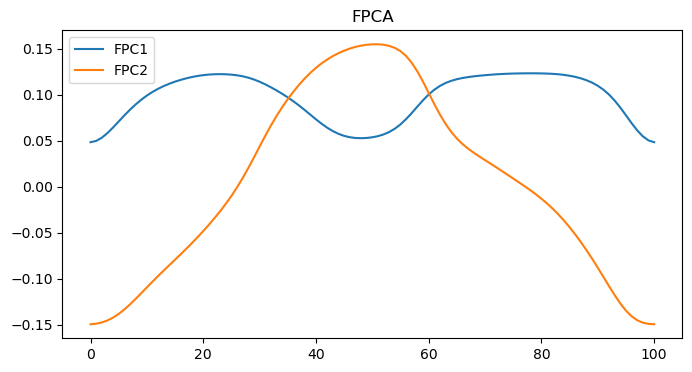

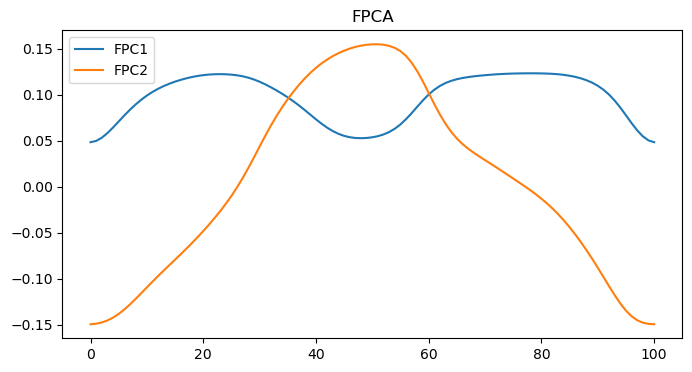

In [131]:
import numpy as np

def standardize_time_series(data_list, log_transform=False, individual=False, across_time_points=False):
    """
    Standardize time series data based on selected options.

    Parameters:
    - data_list: List of lists, where each inner list represents a time series.
    - log_transform: Boolean, if True, apply log transformation to the data before standardizing.
    - individual: Boolean, if True, standardize each time series individually.
    - across_time_points: Boolean, if True, standardize across all time points.

    Returns:
    - List of standardized time series data.
    """

    # Apply log transformation if requested
    if log_transform:
        data_list = np.log1p(data_list)

    if individual:
        # Standardize each series individually
        standardized_data = [(series - np.mean(series)) / np.std(series) for series in data_list]
    
    elif across_time_points:
        # Convert to NumPy array for easier manipulation
        data_array = np.array(data_list)
        # Standardize across all time points
        means = np.mean(data_array, axis=0)
        stds = np.std(data_array, axis=0)
        standardized_data = (data_array - means) / stds
        standardized_data = standardized_data.tolist()
    
    else:
        # Default behavior if neither individual nor across_time_points is specified
        raise ValueError("Either 'individual' or 'across_time_points' must be True.")

    return standardized_data



def compute_and_plot_components(foreground, background, alpha):
    # Define time points
    t = np.linspace(0, 100, 101)
    fd_X = skfda.FDataGrid(foreground, t)
    fd_Y = skfda.FDataGrid(background, t)
    basis = skfda.representation.basis.BSplineBasis(n_basis=7)
    X_basis = fd_X.to_basis(basis)
    Y_basis = fd_Y.to_basis(basis)

    X_fd_data = fd_X.data_matrix.reshape(fd_X.data_matrix.shape[:-1])
    Y_fd_data = fd_Y.data_matrix.reshape(fd_Y.data_matrix.shape[:-1])

    X_identity = np.eye(len(fd_X.grid_points[0]))
    Y_identity = np.eye(len(fd_Y.grid_points[0]))

    X_weights = scipy.integrate.simpson(X_identity, fd_X.grid_points[0])
    Y_weights = scipy.integrate.simpson(Y_identity, fd_Y.grid_points[0])

    X_weights_matrix = np.diag(X_weights)
    Y_weights_matrix = np.diag(Y_weights)

    X_factorization_matrix = X_weights_matrix.astype(float)
    Y_factorization_matrix = Y_weights_matrix.astype(float)

    X_Lt = np.linalg.cholesky(X_factorization_matrix).T
    Y_Lt = np.linalg.cholesky(Y_factorization_matrix).T

    new_data_matrix_X = X_fd_data @ X_weights_matrix
    new_data_matrix_X = np.linalg.solve(X_Lt.T, new_data_matrix_X.T).T

    new_data_matrix_Y = Y_fd_data @ Y_weights_matrix
    new_data_matrix_Y = np.linalg.solve(Y_Lt.T, new_data_matrix_Y.T).T
    
    X_centered = new_data_matrix_X
    Y_centered = new_data_matrix_Y

    # Center the matrix X by subtracting the mean of each column
   # X_centered = new_data_matrix_X - np.mean(new_data_matrix_X, axis=0)
   # Y_centered = new_data_matrix_Y - np.mean(new_data_matrix_Y, axis=0)

    Vx = (1 / (len(foreground) - 1)) * np.dot(X_centered.T, X_centered)
    Vy = (1 / (len(background) - 1)) * np.dot(Y_centered.T, Y_centered)

    # Perform the eigen decomposition on the covariance matrix V
    eigenvalues, eigenvectors = np.linalg.eig(Vx - alpha * Vy)

    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    components = np.linalg.solve(X_Lt, sorted_eigenvectors[:, :5]).T

    # Plot the first three components
    plt.figure(figsize=(8, 4))
    for i in range(2):
        plt.plot(components[i], label=f'Component {i+1}')
    #plt.legend()
    plt.title('FPCA')
    plt.legend(['FPC1', 'FPC2'])
    plt.show()

    return components

standardized_brace_list = standardize_time_series(angle_series_right_leg_condition_2, log_transform=False, individual=False, across_time_points = True)
standardized_normal_list = standardize_time_series(angle_series_right_leg_condition_1, log_transform=False, individual=False, across_time_points=True)


# Example usage:
shared_components = compute_and_plot_components(standardized_brace_list,standardized_brace_list , 0)
unique_components = compute_and_plot_components(standardized_brace_list,standardized_normal_list, 0)

#NON PERIODIC CASE

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps


def calculate_pc_scores_from_lists(data_lists, eigenvector):
    """
    Calculate the PC scores for each time series represented by a list in data_lists.
    
    Parameters:
    - data_lists: List of lists, each inner list is a time series for a company.
    - eigenvector: The eigenvector to use for calculating PC scores.
    - t: The time array over which to integrate.
    
    Returns:
    - A numpy array with PC scores for each time series.
    """
    # Convert data lists to a numpy array for efficient computation
    data_array = np.array(data_lists)
    
    # Calculate the integral using the trapezoidal rule for each time series
    pc_scores = np.array([simps(data_array[i] * np.real(eigenvector), dx = 1) for i in range(data_array.shape[0])])
    return pc_scores

# Calculate PC scores for tech and nontech lists
shared_pc_score1 = calculate_pc_scores_from_lists(standardized_brace_list, shared_components[0])
shared_pc_score2 = calculate_pc_scores_from_lists(standardized_brace_list, shared_components[1])
shared_pc_score3 = calculate_pc_scores_from_lists(standardized_brace_list, shared_components[2])
shared_pc_score4 = calculate_pc_scores_from_lists(standardized_brace_list, shared_components[3])
shared_pc_score5 = calculate_pc_scores_from_lists(standardized_brace_list, shared_components[4])

unique_pc_score1 = calculate_pc_scores_from_lists(standardized_brace_list, unique_components[0])
unique_pc_score2 = calculate_pc_scores_from_lists(standardized_brace_list, unique_components[1])
unique_pc_score3 = calculate_pc_scores_from_lists(standardized_brace_list, unique_components[2])
unique_pc_score4 = calculate_pc_scores_from_lists(standardized_brace_list, unique_components[3])
unique_pc_score5 = calculate_pc_scores_from_lists(standardized_brace_list, unique_components[4])


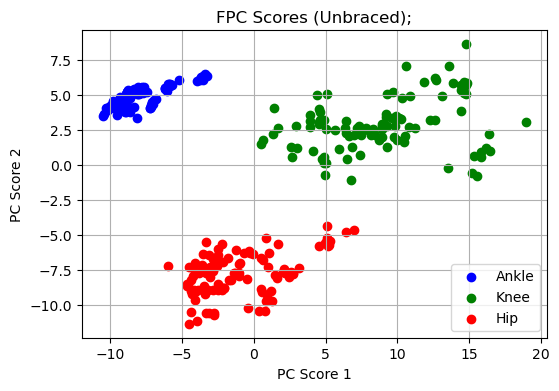

In [133]:
def plot_pc_scores_with_labels(pc_scores1, pc_scores2, joints, title="PC Scores by Joint"):
    plt.figure(figsize=(6, 4))
    # Map joint numbers to colors (adjust these colors as you see fit)
    color_map = {1: 'blue', 2: 'green', 3: 'red'}
    colors = [color_map[joint] for joint in joints]
    
    # Plot each point, now colored by joint
    for i in range(len(pc_scores1)):
        plt.scatter(pc_scores1[i], pc_scores2[i], color=colors[i])
    
    plt.xlabel('PC Score 1')
    plt.ylabel('PC Score 2')
    plt.title(title)
    plt.grid(True)
    
    # Legend
    plt.scatter([], [], color='blue', label='Ankle')
    plt.scatter([], [], color='green', label='Knee')
    plt.scatter([], [], color='red', label='Hip')
    plt.legend()
    
    plt.show()

#\u03b3 = 0
# Example usage
# Assuming you have pc_scores1, pc_scores2, and legs ready
plot_pc_scores_with_labels(unique_pc_score1, unique_pc_score2, joints_condition_1_leg_2, "FPC Scores (Unbraced);")
